In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
sns.set_style('darkgrid')
sns.set_context('notebook')

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Start with some data exploration
Import the files & start exploring them!

In [2]:
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

print("Train and Test variants shape : ",train_variants_df.shape, test_variants_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [3]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
test_text_df.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [5]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
train_text_df['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

Seems like a paper or conference proceeding

## Distributions

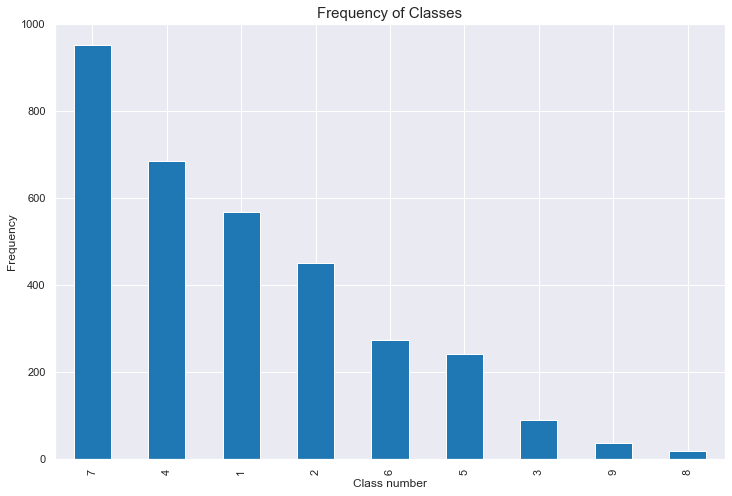

In [7]:
plt.figure(figsize=(12,8))
#sns.countplot(x="Class", data=train_variants_df)
train_variants_df.Class.value_counts().plot(kind='bar')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class number', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

Some classes are much more rare than others

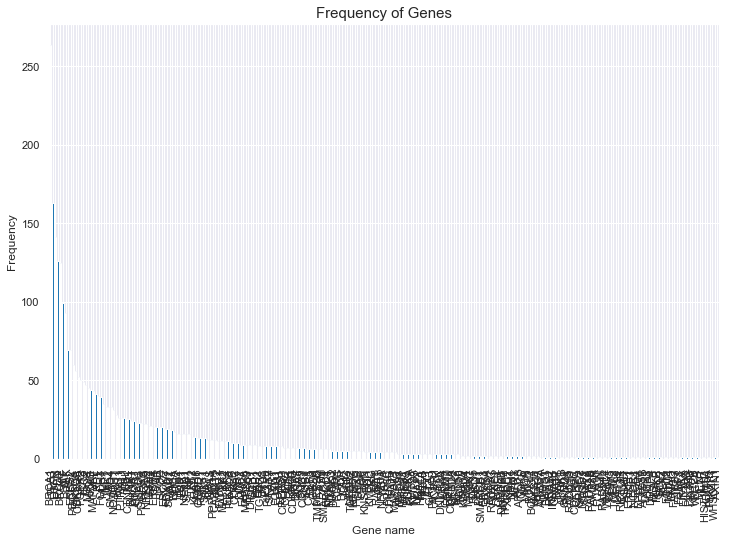

In [8]:
plt.figure(figsize=(12,8))
#sns.countplot(x="Class", data=train_variants_df)
train_variants_df.Gene.value_counts().plot(kind='bar')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Gene name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Genes", fontsize=15)
plt.show()

Seems like some genes are much more prone to mutation than others. Which genes are these?

In [9]:
geneCounts = train_variants_df.Gene.value_counts()
geneCounts.nlargest(20)

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
MTOR       45
KRAS       44
MAP2K1     43
VHL        41
RET        40
Name: Gene, dtype: int64

Are genes and classes correlated?

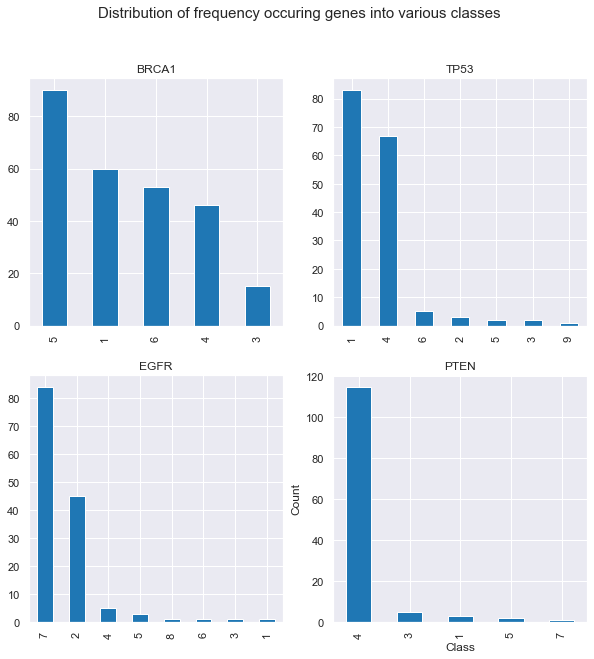

In [10]:
f,axs = plt.subplots(2,2, figsize = (10,10))
f.suptitle("Distribution of frequency occuring genes into various classes", fontsize=15)

train_variants_df.loc[train_variants_df['Gene'] =='BRCA1'].Class.value_counts().plot(kind='bar',ax=axs[0,0])
axs[0,0].set_title('BRCA1')
train_variants_df.loc[train_variants_df['Gene'] =='TP53'].Class.value_counts().plot(kind='bar',ax=axs[0,1])
axs[0,1].set_title('TP53')
train_variants_df.loc[train_variants_df['Gene'] =='EGFR'].Class.value_counts().plot(kind='bar',ax=axs[1,0])
axs[1,0].set_title('EGFR')
train_variants_df.loc[train_variants_df['Gene'] =='PTEN'].Class.value_counts().plot(kind='bar',ax=axs[1,1])
axs[1,1].set_title('PTEN')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

It seems like the gene itself has some predictive power on the class in which it belongs. Now let's look at the variation types.

In [11]:
variationCounts = train_variants_df.Variation.value_counts()
variationCounts.nlargest(20)

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61H                     3
Q61R                     3
G12C                     2
V321M                    2
K117N                    2
R173C                    2
G13V                     2
G12A                     2
Q22K                     2
ETV6-NTRK3 Fusion        2
EWSR1-ETV1 Fusion        2
Name: Variation, dtype: int64

Most mutations are protein-swaps. Does variation correlate wtih class?

In [12]:
# replace X123X variation types with "protein swap" and look at distribution of classes for each variation

mutationTypes = {'Truncating Mutations','Deletion','Amplification','Fusions','Overexpression','ProteinSwap'}

# copy the variation column
train_variants_df['Variation_Alt'] = train_variants_df['Variation']

# replace values
train_variants_df['Variation_Alt'] = np.where(train_variants_df['Variation_Alt'].isin(mutationTypes), train_variants_df['Variation_Alt'], 'ProteinSwap')


In [13]:
train_variants_df['Variation_Alt']

0       Truncating Mutations
1                ProteinSwap
2                ProteinSwap
3                ProteinSwap
4                ProteinSwap
                ...         
3316             ProteinSwap
3317             ProteinSwap
3318                 Fusions
3319             ProteinSwap
3320             ProteinSwap
Name: Variation_Alt, Length: 3321, dtype: object

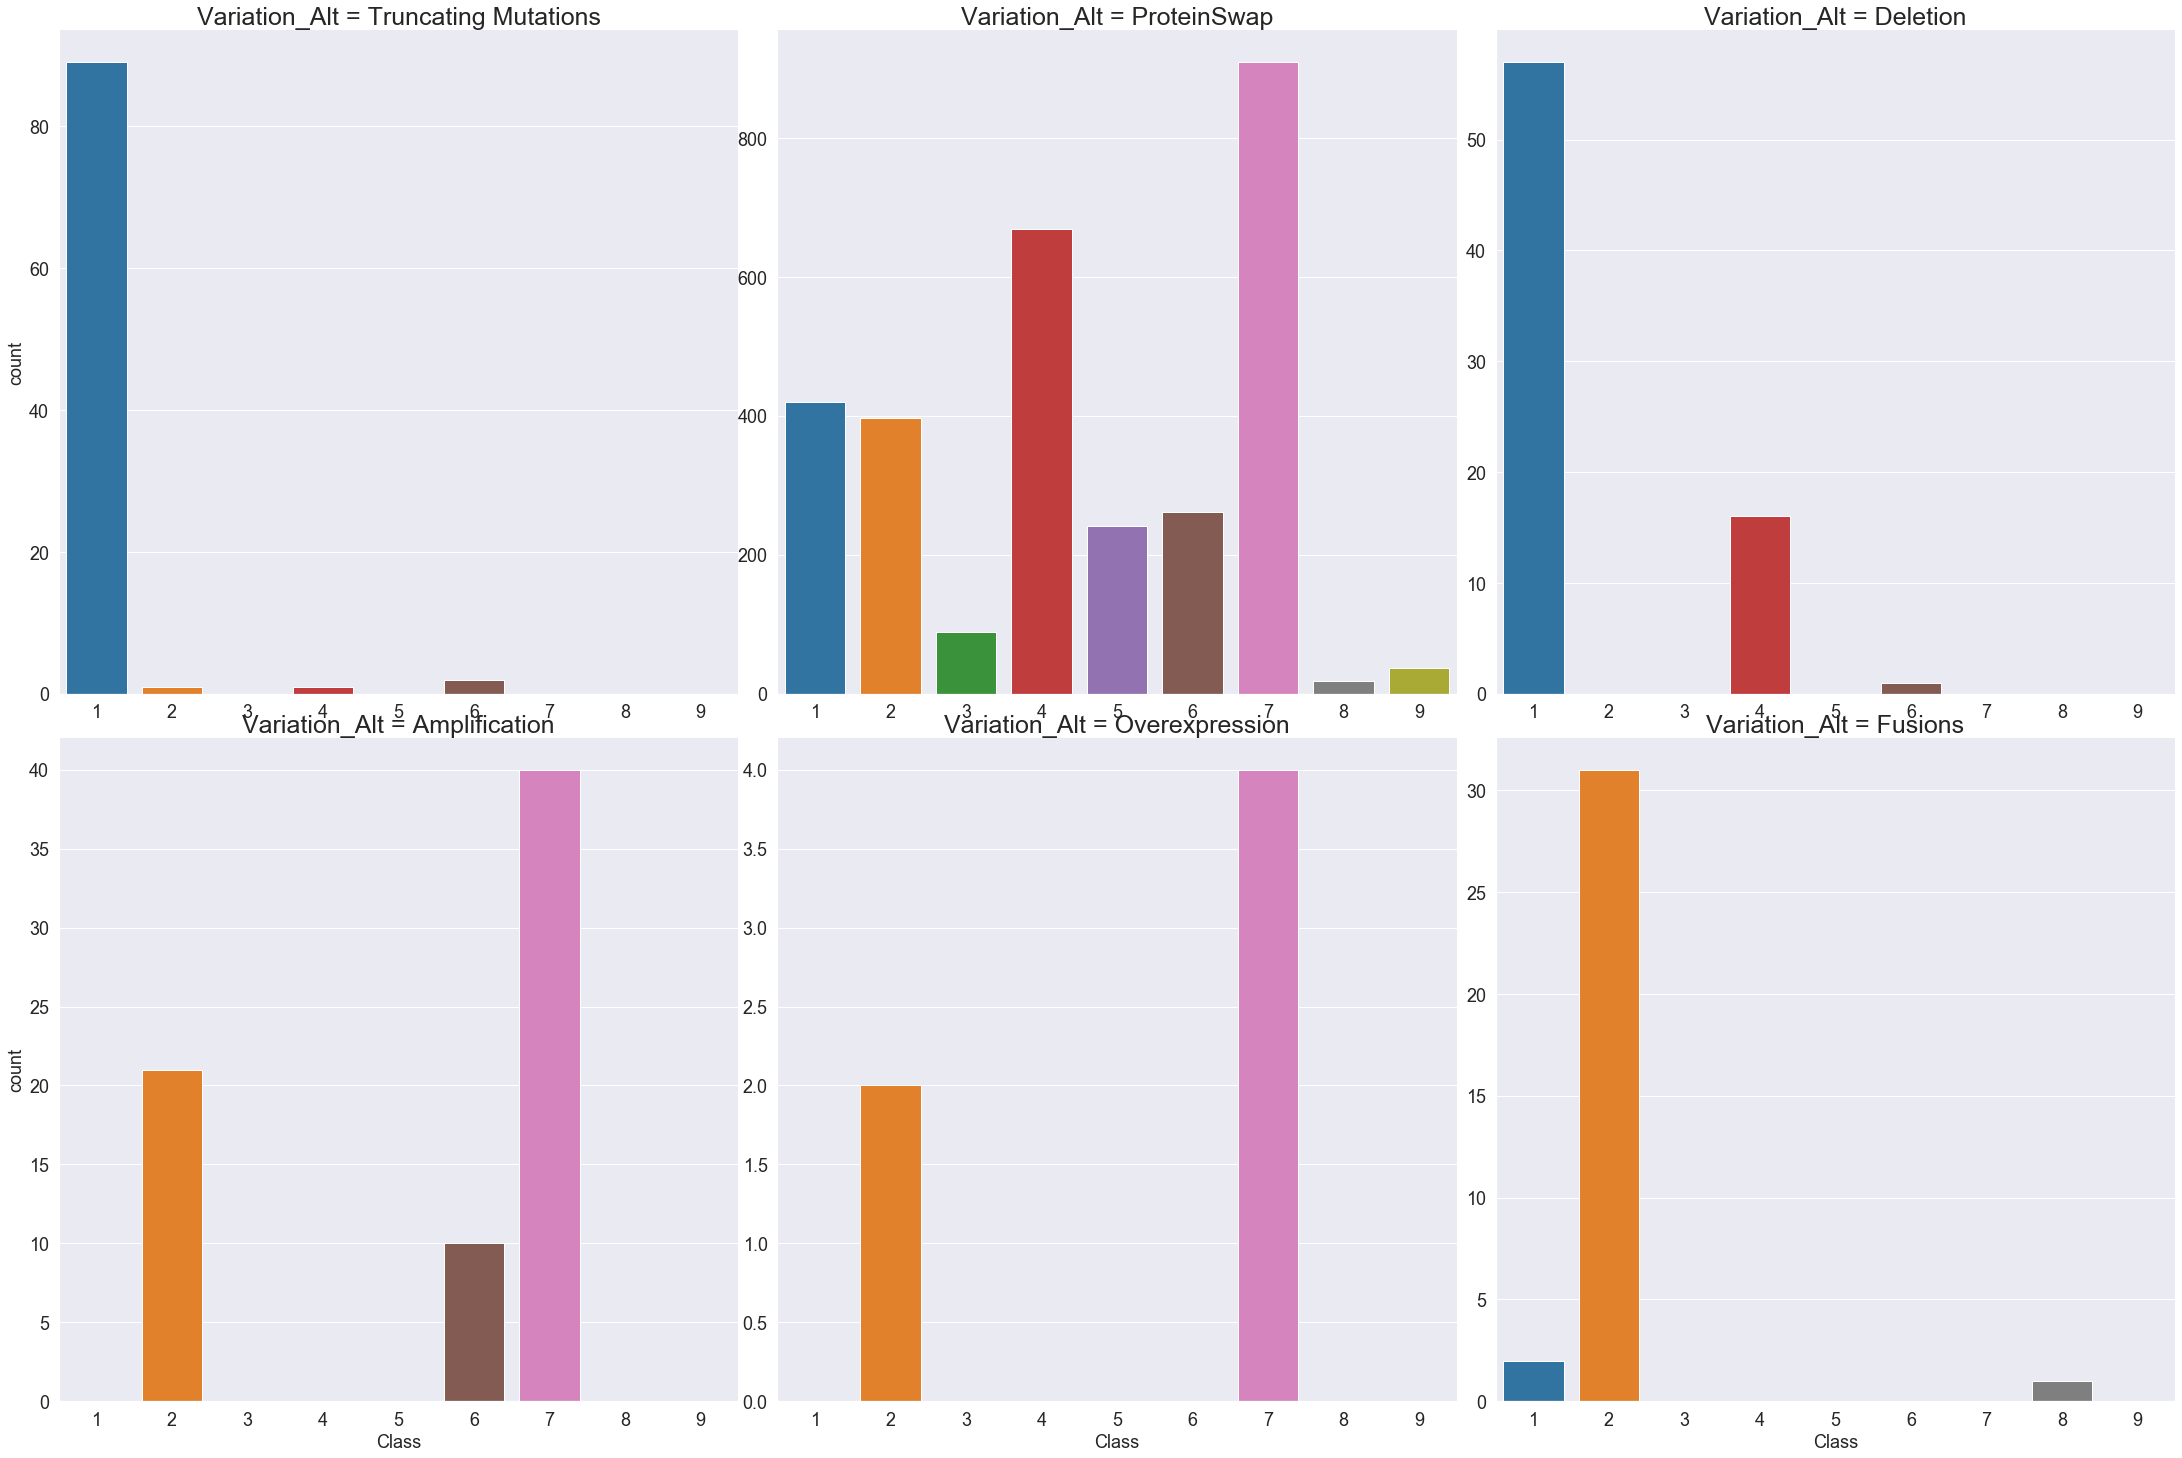

In [14]:
g = sns.catplot(x='Class',data=train_variants_df[['Variation_Alt','Class']],col='Variation_Alt',kind='count',col_wrap=3,
           height = 10,sharey=False,sharex=False)
g.set_yticklabels(size = 18)
g.set_xticklabels(size = 18)
g.set_ylabels(size = 18)
g.set_xlabels(size = 18)
g.set_titles(size = 25)

plt.show()

Seems like the variation type also has some predictive power!

# Interim Summary
Based on their distributions, these variables seem to have some predictive power for the class which a mutation belongs:
* Variation type
* Gene that was mutated

Some other interesting things we saw:
* Seems like some genes are much more prone to mutation than others
* Some classes occur more often than others


## Now let's take a look at the text data

In [15]:
# add information about word count and character count
train_text_df["num_words"] = train_text_df["Text"].apply(lambda x: len(str(x).split()) )
train_text_df["num_chars"] = train_text_df["Text"].apply(lambda x: len(str(x)) )

test_text_df["num_words"] = test_text_df["Text"].apply(lambda x: len(str(x).split()) )
test_text_df["num_chars"] = test_text_df["Text"].apply(lambda x: len(str(x)) )

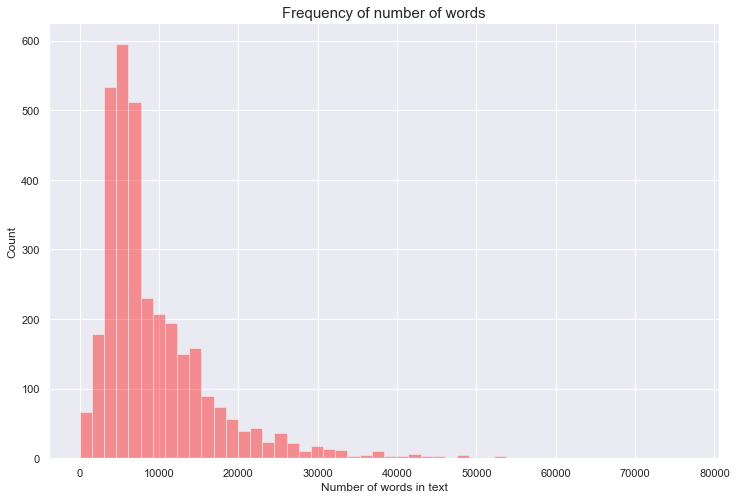

In [16]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

In [17]:
train_text_df.num_words.describe()

count     3321.000000
mean      9542.505872
std       7845.251814
min          1.000000
25%       4733.000000
50%       6871.000000
75%      11996.000000
max      76708.000000
Name: num_words, dtype: float64

While it is interesting that some mutations have a longer text description than others, intuition tells me what it wouldn't make sense for the description length to have predictive power. Notice that the mean word count is 1; let's check if there are any entries with empty text descriptors.

In [18]:
train_text_df[train_text_df["num_words"]<5]

,ID,Text,num_words,num_chars
1109,1109,NaN,1,3
1277,1277,NaN,1,3
1407,1407,NaN,1,3
1639,1639,NaN,1,3
2755,2755,NaN,1,3


This will give us trouble -  let's remove these entries. But first, we should combine the text dataframe with the variants dataframe.

## Combine text data w/ variation data

In [19]:
# first merge dataframes
train_df = train_variants_df.merge(train_text_df, how='inner', left_on='ID', right_on='ID')
test_df = test_variants_df.merge(test_text_df, how='inner', left_on='ID', right_on='ID')

In [20]:
train_df[train_df["num_words"]<500]


,ID,Gene,Variation,Class,Variation_Alt,Text,num_words,num_chars
140,140,EGFR,I491M,5,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
145,145,EGFR,K467T,2,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
259,259,EGFR,S464L,2,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
344,344,CDH1,A617T,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
346,346,CDH1,A634V,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
348,348,CDH1,T340A,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
648,648,CDKN2A,Q50*,4,ProteinSwap,"The p16 gene is located in chromosome 9p21, a ...",103,706
688,688,CDKN2A,R79P,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540
692,692,CDKN2A,G93W,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540
693,693,CDKN2A,V118D,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540


In [21]:
train_df.iloc[2900].Text

'Neurofibromatosis 2 (NF2) is a tumor predisposition syndrome in which affected individuals develop nervous system tumors at an increased frequency. The most common tumor in individuals with NF2 is the schwannoma, which is composed of neoplastic Schwann cells lacking NF2 gene expression. Moreover, inactivation of the NF2 gene is observed in nearly all sporadic schwannomas, suggesting that the NF2 gene is a critical growth regulator for Schwann cells. In an effort to gain insights into the function of the NF2 gene product, merlin or schwannomin, we performed a detailed functional analysis of eight naturally occurring non-conservative missense mutations in the NF2 gene. Using a regulatable expression system in rat schwannoma cells, we analyzed proliferation, actin cytoskeleton-mediated events and merlin folding. In this report, we demonstrate that mutations clustered in the predicted alpha-helical region did not impair the function of merlin whereas those in either the N- or C-terminus o

In [22]:
train_df[train_df['Variation'].str.match('K413E')]

,ID,Gene,Variation,Class,Variation_Alt,Text,num_words,num_chars
2901,2901,NF2,K413E,6,ProteinSwap,Neurofibromatosis type 2 (NF2) is a multiple n...,3863,27293


In [23]:
# remove rows with NaN
train_df = train_df[train_df['Text'].notna()]
test_df = test_df[test_df['Text'].notna()]

train_df[train_df["num_words"]<500]

,ID,Gene,Variation,Class,Variation_Alt,Text,num_words,num_chars
140,140,EGFR,I491M,5,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
145,145,EGFR,K467T,2,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
259,259,EGFR,S464L,2,ProteinSwap,The accurate determination of perfluoroalkyl s...,430,2925
344,344,CDH1,A617T,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
346,346,CDH1,A634V,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
348,348,CDH1,T340A,4,ProteinSwap,E-cadherin is involved in the formation of cel...,187,1315
648,648,CDKN2A,Q50*,4,ProteinSwap,"The p16 gene is located in chromosome 9p21, a ...",103,706
688,688,CDKN2A,R79P,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540
692,692,CDKN2A,G93W,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540
693,693,CDKN2A,V118D,4,ProteinSwap,Cell division is controlled by a series of pos...,228,1540


Some variations have the same text descriptor, and belong to the same class. Some variations have the same text descriptor, but belongs to a separate class (see IDs [140,145,259], and [2906,2908]). This will definitely give us trouble later on...

Let's take a look at the test data

In [24]:
test_df[test_df["num_words"]<500]

,ID,Gene,Variation,Text,num_words,num_chars
206,206,AR,H690P,The estrogen receptor complex is a known trans...,341,2419
527,527,MCFD2,D129E,THE critical pathways through which protein-ty...,487,3272
859,859,MSH2,R621*,Hereditary nonpolyposis colon cancer (HN-PCC) ...,134,882
1193,1193,TYR,C55Y,Familial adenomatous polyposis (FAP) is an aut...,299,2009
1309,1309,LDLR,D175N,"It has previously been shown that, in the hete...",339,2219
1575,1575,NCF1,R42Q,Glioblastoma multiforme (GBM) is the most comm...,401,2803
2765,2765,KRAS,Q25H,Gallbladder cancer (GBC) is more prevalent tha...,272,1688
3299,3299,ARSA,P233T,A 44-year-old male presented with a violaceous...,378,2673
3322,3322,CDKN2A,P73L,Cell division is controlled by a series of pos...,228,1540
3996,3996,BRCA1,A1752G,Abstract Germline mutations in the tumor supp...,165,1127


## Prep solution set & test set (using stage1 solution)

In [25]:
solution = pd.read_csv('stage1_solution_filtered.csv')
solution2 = pd.read_csv('stage_2_private_solution.csv')

In [26]:
solution.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,12,1,0,0,0,0,0,0,0,0
1,19,0,1,0,0,0,0,0,0,0
2,21,0,1,0,0,0,0,0,0,0
3,55,0,0,0,1,0,0,0,0,0
4,64,0,0,0,1,0,0,0,0,0


In [27]:
solution2.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,8,0,0,0,1,0,0,0,0,0
1,15,0,0,0,0,0,0,0,0,1
2,16,0,0,0,0,0,0,0,1,0
3,18,0,1,0,0,0,0,0,0,0
4,19,0,1,0,0,0,0,0,0,0


In [28]:
print('Stage-1 solution has', len(solution), 'entries')
print('Stage-2 solution has', len(solution2), 'entries')
print('The testing set has', len(test_df), 'entries')

Stage-1 solution has 368 entries
Stage-2 solution has 125 entries
The testing set has 5667 entries


We need to address the dimension mismatch by dropping the rows in the test set without a corresponding entry in the solution set.

One way to do this is to
1. merge two dataframes
2. separate merged dataframes into 2 separate truncated dataframes

In [29]:
#combine solution sets
stacked_solution = solution.append(solution2)
stacked_solution.shape

(493, 10)

In [30]:
merge_test_solution = pd.merge(test_df,stacked_solution,on='ID')
merge_test_solution.head()

,ID,Gene,Variation,Text,num_words,num_chars,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,8,CLCF1,R197L,NPM1 gene at chromosome 5q35 is involved in re...,3737,25881,0,0,0,1,0,0,0,0,0
1,12,TET2,Y1902A,TET proteins oxidize 5-methylcytosine (5mC) on...,7123,46418,1,0,0,0,0,0,0,0,0
2,15,EFNB1,M158V,Mutations leading to activation of the RAF-mit...,10126,67612,0,0,0,0,0,0,0,0,1
3,16,PKHD1,V3471G,Janus (Jak) tyrosine kinases contain a tyrosin...,10372,69262,0,0,0,0,0,0,0,1,0
4,18,PGK1,T352N,The actions of RhoA in cytoskeletal regulation...,5868,39859,0,1,0,0,0,0,0,0,0


In [31]:
solution_df_truncated = merge_test_solution.iloc[:,6:6+9]
solution_df_truncated.index = merge_test_solution.ID
print('size of combined & truncated solution is', solution_df_truncated.shape)
solution_df_truncated.head()

size of combined & truncated solution is (492, 9)


,class1,class2,class3,class4,class5,class6,class7,class8,class9
ID,,,,,,,,,
8,0,0,0,1,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,1
16,0,0,0,0,0,0,0,1,0
18,0,1,0,0,0,0,0,0,0


In [32]:
test_df_truncated = merge_test_solution.iloc[:,0:6]
print('size of truncated test set is', test_df_truncated.shape)
test_df_truncated.head()

size of truncated test set is (492, 6)


,ID,Gene,Variation,Text,num_words,num_chars
0,8,CLCF1,R197L,NPM1 gene at chromosome 5q35 is involved in re...,3737,25881
1,12,TET2,Y1902A,TET proteins oxidize 5-methylcytosine (5mC) on...,7123,46418
2,15,EFNB1,M158V,Mutations leading to activation of the RAF-mit...,10126,67612
3,16,PKHD1,V3471G,Janus (Jak) tyrosine kinases contain a tyrosin...,10372,69262
4,18,PGK1,T352N,The actions of RhoA in cytoskeletal regulation...,5868,39859


We'll use `test_df_truncated` and `solution_df_truncated` from here on.

Here's another way to accomplish the same thing. It's less streamlined but yields a bit more information. This code is just here as an example, you can ignore it if you wish.

In [33]:
IDs_to_drop = set(test_df.ID) - set(solution.ID)
test_df_stage1 = test_df.drop(labels=list(IDs_to_drop))
print('The solution has', len(solution), 'entries')
print('The testing set has', len(test_df), 'entries')
print('The truncated testing set has', len(test_df_stage1), 'entries')

The solution has 368 entries
The testing set has 5667 entries
The truncated testing set has 367 entries


Why is there a size discrepency?

In [34]:
# find the ID that exists in one set but not the other
set(test_df_stage1.ID).symmetric_difference(set(solution.ID))

{1623}

In [35]:
test_text_df[test_text_df.ID==1623]

,ID,Text,num_words,num_chars
1623,1623,NaN,1,3


Because one entry from the solution set is associated with a NaN text entry.

In [36]:
# so now we have to drop this row.
# notice that the earlier solution using pd.merge does this entire process in one step
row_to_drop = solution[solution.ID==1623].index
solution_df_stage1 = solution.drop(labels=row_to_drop)

# Clean text data

In [37]:
import string
import re #regular expressions
from nltk.corpus import stopwords
# note: to use stopwords, first do nltk.download() to download the various corpi in nltk.

# TO DO:
# we should remove the references from the text field!! e.g., if there are references like (1,2) or [5][6]
# use regex expression to clean these up!

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)

def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

In [38]:
allText_train = train_df['Text'].apply(cleanup)
allText_test = test_df_truncated['Text'].apply(cleanup)

In [39]:
# before
train_df['Text'][0][1500:2500]

'molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces re

In [40]:
# after
allText_train[0][1500:2500]

' 20 ago 3 4  cdk10 remains one two cdks without identified cyclin partner knowledge gap largely impeded exploration biological functions cdk10 act positive cell cycle regulator cells 5 6 tumor suppressor others 7 8  cdk10 interacts ets2 vets erythroblastosis virus e26 oncogene homolog 2 transcription factor inhibits transcriptional activity unknown mechanism 9  cdk10 knockdown derepresses ets2 increases expression craf protein kinase activates mapk pathway induces resistance mcf7 cells tamoxifen 6 here deorphanize cdk10 identifying cyclin m product fam58a binding partner mutations gene predict absence truncation cyclin associated star syndrome whose features include toe syndactyly telecanthus anogenital renal malformations heterozygous females 10  however functions cyclin pathogenesis star syndrome remain unknown show recombinant cdk10cyclin heterodimer active protein kinase phosphorylates ets2 vitro cyclin silencing phenocopies cdk10 silencing increasing craf phosphoerk expression le

In [41]:
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [42]:
sentences_train = constructLabeledSentences(allText_train)
sentences_test = constructLabeledSentences(allText_test)
sentences_train[0]

C:\Users\Kenny\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys


LabeledSentence(words=['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety', 'fundamental', 'cellular', 'processes', 'cdk10', 'stands', 'one', 'last', 'orphan', 'cdks', 'activating', 'cyclin', 'identified', 'kinase', 'activity', 'revealed', 'previous', 'work', 'shown', 'cdk10', 'silencing', 'increases', 'ets2', 'vets', 'erythroblastosis', 'virus', 'e26', 'oncogene', 'homolog', '2', 'driven', 'activation', 'mapk', 'pathway', 'confers', 'tamoxifen', 'resistance', 'breast', 'cancer', 'cells', 'precise', 'mechanisms', 'cdk10', 'modulates', 'ets2', 'activity', 'generally', 'functions', 'cdk10', 'remain', 'elusive', 'demonstrate', 'cdk10', 'cyclindependent', 'kinase', 'identifying', 'cyclin', 'activating', 'cyclin', 'cyclin', 'm', 'orphan', 'cyclin', 'product', 'fam58a', 'whose', 'mutations', 'cause', 'star', 'syndrome', 'human', 'developmental', 'anomaly', 'whose', 'features', 'include', 'toe', 'syndactyly', 'telecanthus', 'anogenital', 'renal', 'malformations', 'show', 'star', 'synd

# Classification w/ Doc2Vec
https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_doc2vec_lee.html

In [43]:
from gensim.models import Doc2Vec

Text_INPUT_DIM=300
filename='docEmbeddings_5_clean.d2v'

if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences_train)
    text_model.train(sentences_train, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

In [44]:
# grab the training data vectors learned by Dov2Vec
text_train_arrays = text_model.docvecs.vectors_docs

## Predict on test set

In [45]:
# turn the test set into embedded vectors based on text_model
test_size = len(test_df_truncated)
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(test_size):
    text_test_arrays[i] = text_model.infer_vector(sentences_test[i][0])

In [46]:
# Find the class and ID of the document most similar to each of the test examples

#print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % text_model)
#for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
#    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_df.iloc[int(sims[index][0].split('_')[1])].Text)))
#train_df.iloc[most_similar_index].Text
test_size = len(test_df_truncated)
pred_class = np.zeros((test_size, 1))
pred_ID = np.zeros((test_size, 1))

for i in range(test_size):
    sims = text_model.docvecs.most_similar([text_test_arrays[i]], topn=len(text_model.docvecs))
    most_similar_index = int(sims[0][0].split('_')[1])
    j = 1
    while most_similar_index > len(train_df):
        most_similar_index = int(sims[j][0].split('_')[1])
        j = j+1
    pred_class[i] = train_df.iloc[most_similar_index].Class
    pred_ID[i] = test_df_truncated.iloc[i].ID
   


In [48]:
# one hot -> series
sol_size = len(solution_df_truncated)
desired_class = np.zeros((sol_size,1))
desired_ID = np.zeros((sol_size,1))

for i in range(sol_size):
    desired_class[i] = np.where(solution_df_truncated.iloc[i] == 1)[0][0]+1
    desired_ID[i] =  solution_df_truncated.index[i]

In [49]:
y_pred = pred_class.ravel()
y_true = desired_class.ravel()
print(type(y_pred))
print(type(y_true))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


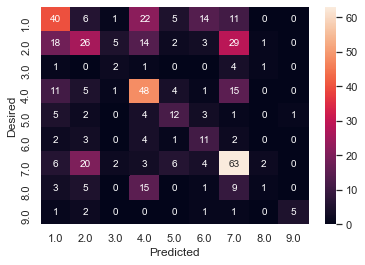

In [50]:
# build confusion matrix
confusion = pd.crosstab(y_true,y_pred,margins = False)
sns.heatmap(confusion,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Desired')
plt.show()

In [51]:
# some basic metrics of this result
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

print(classification_report(y_true,y_pred))
print('MCC:', matthews_corrcoef(y_true,y_pred))

              precision    recall  f1-score   support

         1.0       0.46      0.40      0.43        99
         2.0       0.38      0.27      0.31        98
         3.0       0.18      0.22      0.20         9
         4.0       0.43      0.56      0.49        85
         5.0       0.40      0.43      0.41        28
         6.0       0.29      0.48      0.36        23
         7.0       0.47      0.59      0.52       106
         8.0       0.20      0.03      0.05        34
         9.0       0.83      0.50      0.62        10

    accuracy                           0.42       492
   macro avg       0.40      0.39      0.38       492
weighted avg       0.41      0.42      0.41       492

MCC: 0.3072630287391503


In [52]:
# save our results so far as "cleaned" data
import pickle

# Saving the objects:
with open('cleaned_train.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_df, test_df, test_df_truncated, solution_df_truncated,
                 desired_class, desired_ID,
                 text_train_arrays, text_test_arrays], f)
    


What is are the metrics if we assess the training set set?

In [54]:
# Don't have to run this line since these variables already exist in your workspace
import pickle

train_df, test_df, test_df_truncated, solution_df_truncated,desired_class, desired_ID,text_train_arrays, text_test_arrays = pickle.load( open( "cleaned_train.pkl", "rb" ) )


In [55]:
train_size = train_df.shape[0]
pred_class = np.zeros((train_size, 1))
pred_ID = np.zeros((train_size, 1))

for i in range(train_size):
    sims = text_model.docvecs.most_similar([text_train_arrays[i]], topn=len(text_model.docvecs))
    most_similar_index = int(sims[0][0].split('_')[1])
    j = 1
    while most_similar_index >= len(train_df):
        most_similar_index = int(sims[j][0].split('_')[1])
        j = j+1
    pred_class[i] = train_df.iloc[most_similar_index].Class
    pred_ID[i] = train_df.iloc[i].ID
    
    

In [56]:
desired_class = train_df.Class

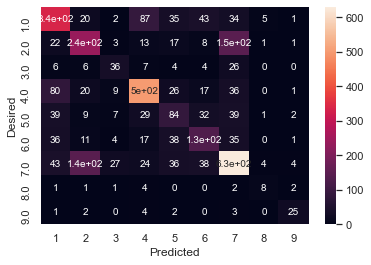

In [57]:
# build confusion matrix
confusion = pd.crosstab(pred_class.ravel(),desired_class,margins = False)
sns.heatmap(confusion,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Desired')
plt.show()

In [58]:
print(classification_report(desired_class,pred_class.ravel()))
print('MCC:', matthews_corrcoef(desired_class,pred_class.ravel()))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60       566
           2       0.53      0.53      0.53       452
           3       0.40      0.40      0.40        89
           4       0.73      0.73      0.73       686
           5       0.35      0.35      0.35       242
           6       0.48      0.48      0.48       273
           7       0.66      0.66      0.66       952
           8       0.42      0.42      0.42        19
           9       0.68      0.68      0.68        37

    accuracy                           0.60      3316
   macro avg       0.54      0.54      0.54      3316
weighted avg       0.60      0.60      0.60      3316

MCC: 0.5095497301461036


As expected, performance is higher when evaluating on the training set